<a href="https://colab.research.google.com/github/aleksey-sut/portfolio/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from io import BytesIO
from PIL import Image

import tensorflow as tf
from tensorflow import keras

In [3]:
upl = files.upload()

Saving img.JPG to img.JPG
Saving img_style.png to img_style.png


In [4]:
img = Image.open(BytesIO(upl['img.JPG']))
img_style = Image.open(BytesIO(upl['img_style.png']))

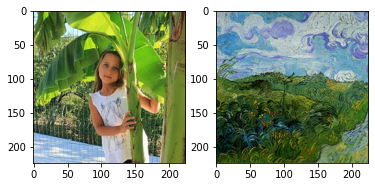

In [5]:
plt.subplot(1, 2, 1)
plt.imshow( img )
plt.subplot(1, 2, 2)
plt.imshow( img_style )
plt.show()


 Далее, планируется использовать сеть VGG19, поэтому наши изображения нужно преобразовать во входной формат этой сети.  
 Здесь метод preprocess_input преобразовывает изображение из формата RGB в формат BGR и, кроме того, уменьшает средние значения каждого цветового канала на величины:

(B) 103.939, (G) 116.779 и (R) 123.68

In [6]:
x_img = keras.applications.vgg19.preprocess_input( np.expand_dims(img, axis=0) )
x_style = keras.applications.vgg19.preprocess_input(np.expand_dims(img_style, axis=0))

Поэтому, чтобы вернуть изображение в исходный формат RGB, сразу определим такую функцию:

In [7]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x


Загрузим обученную сеть VGG19, но без полносвязной НС на ее конце (она нам не нужна):  
Здесь параметр include_top=False как раз отбрасывает полносвязную сеть, а параметр weights='imagenet' указывает загрузить веса, обученные на базе 10 миллиона изображений базы ImageNet. vgg.trainable запрещает изменять веса, то есть, проводить обучение этой сети.

In [8]:
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

80134624/80134624 [==============================] - 1s 0us/step


В дальнейшем нам нужно будет работать с этой сетью, подавать на ее вход изображения и брать на выходах определенных слоев вычисленные карты признаков:  

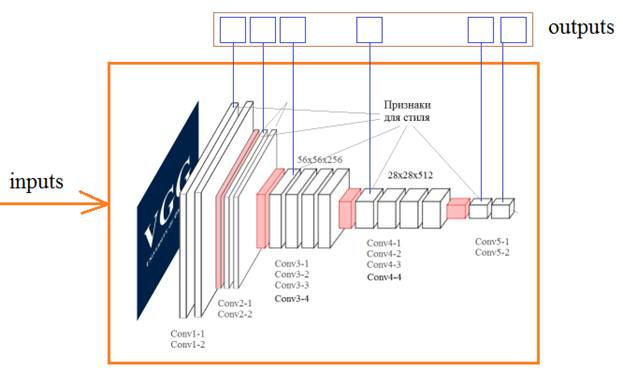


Как это лучше сделать? Для этого мы создадим новую сеть на базе VGG19, используя класс:

keras.models.Model(inputs = None, outputs = None, name)

Этот класс позволяет относительно легко строить произвольные архитектуры сетей. Как он это делает? Я здесь сделаю небольшое отступление, чтобы пояснить этот важный момент. Сморите, в Tensorflow слои можно создавать связанные друг с другом. Например, мы сначала создаем первый входной слой:

`inputs = keras.Input(shape=(784,), name='img')  `
и хотим его связать со следующим полносвязным слоем. Для этого мы его создаем:  
`dense_64 = layers.Dense(64, activation='relu')`  
а, затем, связываем с входным:  
`x = dense_64(inputs)`  
Вот такая запись, фактически, определяет направленный граф от вершин inputs к полносвязному слою dense из 64 нейронов и на последний ссылается переменная x:  
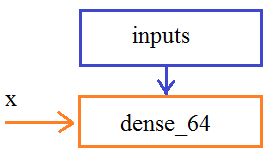  


Все это можно записать и короче:  
`x = layers.Dense(64, activation='relu')(inputs)`  
По аналогии, добавим еще два слоя:  
`x = layers.Dense(64, activation='relu')(x)`
`outputs = layers.Dense(10, activation='softmax')(x)`  
В результате, у нас получится вот такой граф слоев:  

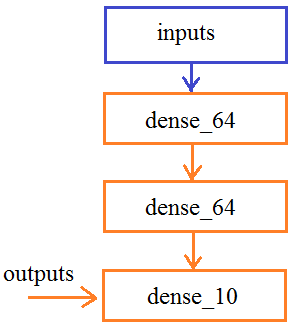

Вот именно так мы и создадим копию сети VGG19. Сначала выделим из нее выходы слоев с именами:

In [9]:
print(vgg.summary())      # вывод структуры НС в консоль для выбора слоев

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [10]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

In [11]:
# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

In [12]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

 обращаемся к слоям по именам и помещаем в список объект выхода каждого из них.

In [13]:
style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]

Далее, сформируем общий список выходных слоев и отобразим их в консоли:

In [14]:
model_outputs = style_outputs + content_outputs

print(vgg.input)
for m in model_outputs:
  print(m)

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='block3_conv1/Relu:0', description="created by layer 'block3_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block5_conv1/Relu:0', description="created by layer 'block5_conv1'")
K

 сформируем копию сети VGG19 с требуемыми выходами:

Кроме того, мы здесь указываем, что весовые коэффициенты изменять нельзя, т.к. сеть уже обучена и менять ее не нужно. Особенность этой модели еще и в том, что пропуская через нее какое-либо изображение, будем получать тензор выходных значений в соответствии со списком model_outputs. Например: `outs = model(x_img)`  
даст значения выходных карт признаков со всех шести слоев:

block1_conv1, block2_conv1, block3_conv1, block4_conv1, block5_conv1, block5_conv2


In [15]:
model = keras.models.Model(vgg.input, model_outputs)
for layer in model.layers:
    layer.trainable = False

print(model.summary())      # вывод структуры НС в консоль

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Это, как раз то, что нам нужно. Причем, сеть будет состоять из обученных весов, так как они тоже копируются при ее создании. Поэтому, мы можем теперь относительно просто реализовать функцию для выделения необходимых признаков для контентного и стилевого изображений:

Вначале пропускаем через модель оба изображения и на выходе получаем их признаки на соответствующих слоях. Затем, формируем список из карт стилевого изображения (это первые пять слоев) (здесь style_layer[0] записан, чтобы взять только трехмерный тензор самих карт и отбросить ненужную первую размерность). Аналогично для карт контента (это последний 6-й выходной слой).

In [16]:
def get_feature_representations(model):
  # batch compute content and style features
  style_outputs = model(x_style)
  content_outputs = model(x_img)
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

Получим начальные стили для наших исходных изображений. Определим функции для вычисления потерь формируемого изображения. Эта функция состоит из суммы двух критериев: рассогласование по контенту и стилю. Начнем с первого. Средний квадрат разницы по контенту можно вычислить с использованием встроенных методов пакета Tensorflow:

In [17]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

Здесь первый метод square() возвращает тензор квадратов разностей между признаками контентного изображения и формируемого (target). А второй метод reduce_mean() вычисляет среднее арифметическое от полученного тензора квадратов. В результате, имеем вычисления по формуле:

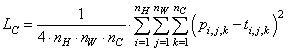

Для вычисления потерь по стилю, вначале определим функцию вычисления матрицы Грама для переданного ей тензора:

In [18]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

Тензор представлен в формате:  

image.png


Поэтому, первая строка возвращает число каналов слоя. Затем, мы вытягиваем этот тензор в матрицу:

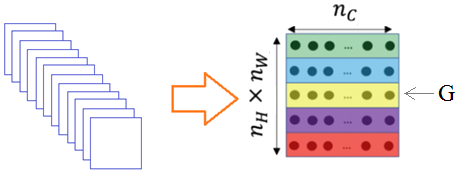

Запоминаем размерность

image.png

И делаем матричное вычисление с последующим делением на n (усредняем величины):

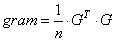

Теперь, мы можем реализовать функцию, которая будет вычислять сумму квадратов рассогласований между картами стилей формируемого изображения и стилевого:

In [19]:
def get_style_loss(base_style, gram_target):
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

Здесь base_style – карта стилей формируемого изображения; gram_target – матрица Грама соответствующего слоя l стилевого изображения. Затем, вычисляется матрица Грама формируемого изображения и их квадрат рассогласования (эту функцию мы будем вызывать для каждого слоя l=1,2,3,4,5):

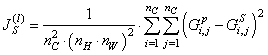

Наконец, общая функция для вычисления всех потерь, будет выглядеть так:

In [20]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
 
  model_outputs = model(init_image)
 
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

Здесь content_weight и style_weight – это параметры a,b в формуле вычисления общих потерь:

image.png

Далее, мы пропускаем через модель формируемое изображение и на выходе получаем тензоры карт признаков на каждом заданном выходном слое. Разделяем эти карты на карты стилей и контента. И определяем вспомогательные переменные, где будем хранить величины потерь для стиля и контента. Затем, определяем веса weight_per_style_layer для суммирования потерь стилей каждого слоя. И делаем цикл, перебирая ранее вычисленные матрицы Грама стилевого изображения и карты признаков для каждого выхода сети формируемого изображения. В цикле суммируем квадраты рассогласований для каждого слоя, получаем вычисления по формуле:

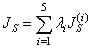

И то же самое выполняем для контентного слоя. Только он один, поэтому цикл сработает только один раз и, фактически, мы здесь просто вычисляем средний квадрат рассогласования по картам признаков последнего выходного слоя.

После вычисления показателей качества, мы их умножаем на величины  и суммируем. Получается общий показатель качества для формируемого изображения.

определяем число итераций работы алгоритма и параметры  для учета веса контента в формируемом изображении и стилей:

In [21]:
num_iterations=500
content_weight=1e3
style_weight=1e-2

Затем, вычисляем карты стилей и контента для начальных изображений:

In [22]:
style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

После этого формируем начальное изображение, как копию контентного:

In [23]:
init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)

Указываем оптимизатор Adam для алгоритма градиентного спуска, номер текущей итерации, переменные для хранения минимальных потерь и лучшего стилизованного изображения и кортеж параметров альфа и бета:

In [24]:
opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)
iter_count = 1
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight)

Сформируем словарь конфигурации:

In [25]:
cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
}

Вспомогательные переменные для преобразования формируемых изображений в формат RGB, а также коллекцию для хранения изображений на каждой итерации:

In [26]:
norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []

 Запуск самого алгоритма градиентного спуска, то есть, формирования стилизованного изображения:

In [ ]:
for i in range(num_iterations):
    with tf.GradientTape() as tape: 
       all_loss = compute_loss(**cfg)
    
    loss, style_score, content_score = all_loss
    grads = tape.gradient(loss, init_image)

    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

      # Use the .numpy() method to get the concrete numpy array
      plot_img = deprocess_img(init_image.numpy())
      imgs.append(plot_img)
      print('Iteration: {}'.format(i), f'Loss: {loss}' )      

Iteration: 0 Loss: 373103072.0
Iteration: 1 Loss: 201743824.0


Смотрите, как здесь все работает. Функция compute_loss пропускает формируемое изображение через НС и возвращает значения потерь. Но мы вызываем модель в области видимости объекта GradientTape, который записывает все величины на каждом нейроне сети в момент прогонки изображения. Затем, мы используем записанные значения, чтобы вычислить градиент для изменяемых параметров, минимизируя общие потери. Так как изменяемые параметры – это пиксели изображения, то именно их мы и указываем в методе gradient. Затем, применяем вычисленный градиент для изменения пикселей. Так с помощью Tensorflow можно делать градиентный спуск для выбранных изменяемых параметров, минимизируя отклик сети в соответствии с заданным критерием качества. Более подробно о GradientTape можно почитать на странице официальной документации:

https://www.tensorflow.org/api_docs/python/tf/GradientTape

Далее, мы ограничиваем значения пикселей изображения минимальными и максимальными границами и запоминаем лучшее. В конце выводим то, что получилось в лучшем варианте. Давайте запустим этот алгоритм и посмотрим что получится.



In [ ]:
plt.imshow(best_img)
print(best_loss)

In [ ]:
image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image.save("result.jpg")
files.download("result.jpg")